# Data Preprocessing - imputation by analyzing by semantically similar groups of factors

In this notebook, we attempt to conduct data imputation by analyzing the factors that are semantically similar to each other, and check if they are interchangable or not. 

The google docs for the similar factors is shown [here](https://docs.google.com/document/d/1iSZYiolLmyTKLHlo-tGlhpErKTOPJA4T72hZgv4QA5w/edit?usp=sharing)


Specifically, the data imputation consists of two steps:
1. Check the colinearity among semantically-similar columns
2. If we observe a certain level of colinearity, check if their raw values, or the normalized values are interchanagable.

# 0. Data & Package Import & Function Definition

We first import necessary packages and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from numpy.linalg import eigvals

In [2]:
df = pd.read_csv('../database/2016-2022.csv')

Then, we define necessary functions:
- **analyze_columns**: check multicolinearity
    - correlation matrix
    - eigenvalues
    - condition number
    - VIFs
- **normalized_difference**: check interchangability of normalized values.

In [3]:
# 1. multicolinearity test: correlation matrix, eigenvalues, condition number, and VIFs
def analyze_columns(df, cols, labels=None):
    # Drop rows with NaN or inf values in the specified columns
    df_clean = df[cols].replace([np.inf, -np.inf], np.nan).dropna(subset=cols)
    
    # 1. Correlation matrix heatmap
    print("1. Correlation matrix")
    corr = df_clean[cols].corr()
    
    if not labels:
        labels = cols

    plt.figure(figsize=(4, 4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, xticklabels=labels, yticklabels=labels)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # 2. Eigenvalues
    eigenvalues = eigvals(corr)
    print(f"\n2. Eigenvalues: {eigenvalues}\n")

    # 3. Condition number
    condition_number = np.sqrt(eigenvalues.max() / eigenvalues.min())
    print(f"3. Condition Number: {condition_number}\n")

    # 4. VIF
    print("4. VIF:")
    X = df_clean[cols].assign(const=1)  # adding a constant for the intercept
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)
    print("\n" + "-"*50 + "\n")


def normalized_difference(df, col1, col2):
    # Normalize the values of col1 and col2
    df[f'{col1}_normalized'] = (df[col1] - df[col1].mean()) / df[col1].std()
    df[f'{col2}_normalized'] = (df[col2] - df[col2].mean()) / df[col2].std()

    # Compute the difference between the two normalized values
    df['difference_normalized'] = df[f'{col1}_normalized'] - df[f'{col2}_normalized']

    # Drop rows where either col1_normalized, col2_normalized, or difference_normalized is NaN or infinite
    df_clean_normalized = df.dropna(subset=[f'{col1}_normalized', f'{col2}_normalized', 'difference_normalized'])
    df_clean_normalized = df_clean_normalized[np.isfinite(df_clean_normalized['difference_normalized'])]

    # Plotting
    plt.figure(figsize=(4, 4))
    sns.histplot(df_clean_normalized['difference_normalized'], bins=100, kde=True, color='skyblue', edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of Difference between Normalized {col1} and {col2}')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Summary statistics for normalized values
    mean_diff_normalized = df_clean_normalized['difference_normalized'].mean()
    std_diff_normalized = df_clean_normalized['difference_normalized'].std()
    conf_interval_normalized = stats.t.interval(0.95, len(df_clean_normalized['difference_normalized'])-1, loc=mean_diff_normalized, scale=std_diff_normalized/np.sqrt(len(df_clean_normalized['difference_normalized'])))

    # Print correlation
    correlation = df[col1].corr(df[col2])
    print(f"Correlation between {col1} and {col2}: {correlation:.6f}")
    
    # Print summary statistics
    print(f"\nMean Difference (Normalized): {mean_diff_normalized:.6f}")
    print(f"Standard Deviation (Normalized): {std_diff_normalized:.6f}")
    print(f"95% Confidence Interval (Normalized): ({conf_interval_normalized[0]:.6f}, {conf_interval_normalized[1]:.6f})")


# 1. total_return_##

The **total_return_##** field is shown below:
- total_return_5y
- total_return_4y
- total_return_3y
- total_return_2y
- total_return_1y
- total_return_6m
- total_return_3m

## 1.1 Check colinearity

We do 4 things as shown below in order to check multicolinearity:
1. Correlation matrix heatmap
2. Eigenvalues of the correlation matrix (very small eigenvalues indicate the presence of multicollinearity)
3. Condition number of the correlation matrix (A large condition number indicates multicollinearity)
4. VIF (a VIF above 5-10 indicates a problematic amount of collinearity)

1. Correlation matrix


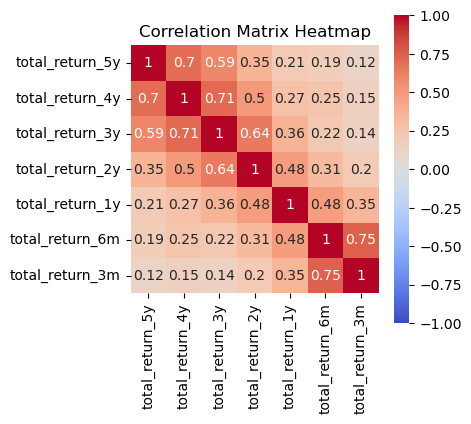


2. Eigenvalues: [3.32722128 1.60268312 0.81037339 0.48985179 0.29352075 0.25697401
 0.21937567]

3. Condition Number: 3.8944543397582887

4. VIF:
          Variable       VIF
0  total_return_5y  2.038341
1  total_return_4y  2.742192
2  total_return_3y  2.793333
3  total_return_2y  1.977232
4  total_return_1y  1.549863
5  total_return_6m  2.668100
6  total_return_3m  2.287625
7            const  1.195109

--------------------------------------------------



In [4]:
cols = ['total_return_5y','total_return_4y','total_return_3y','total_return_2y','total_return_1y','total_return_6m','total_return_3m']
analyze_columns(df, cols)

To conclude:
1. Neighbouring return values have high correlations in the range of roughly 0.5~0.7
2. Eigenvalues are pretty small but not sure of the thresholds
3. Condition number is 4, which is moderate
4. VIF values for all the variables is below 5, which is on the acceptable level.

As we observe a certain level of correlations among the neighboring values, we check the distribution of the differences. 

## 1.2 Check interchangability

### 1.2.1 total_return_5y, total_return_4y

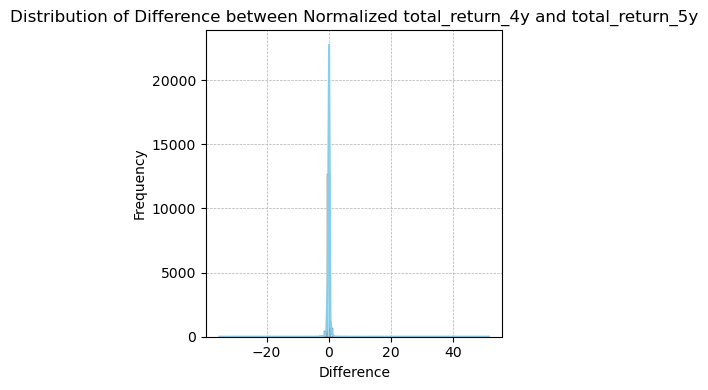

Correlation between total_return_4y and total_return_5y: 0.698168

Mean Difference (Normalized): 0.003382
Standard Deviation (Normalized): 0.782765
95% Confidence Interval (Normalized): (-0.009575, 0.016339)


In [5]:
normalized_difference(df, 'total_return_4y', 'total_return_5y')

### 1.2.2 total_return_4y, total_return_3y

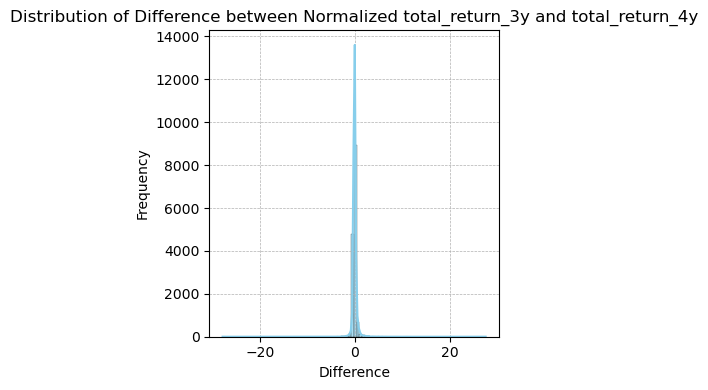

Correlation between total_return_3y and total_return_4y: 0.719833

Mean Difference (Normalized): 0.007524
Standard Deviation (Normalized): 0.750573
95% Confidence Interval (Normalized): (-0.004490, 0.019538)


In [6]:
normalized_difference(df, 'total_return_3y', 'total_return_4y')

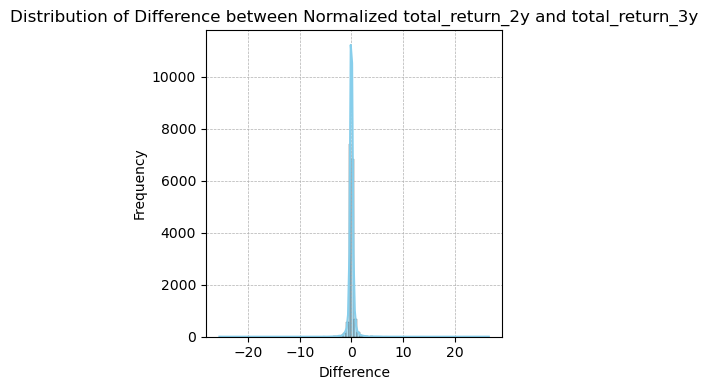

Correlation between total_return_2y and total_return_3y: 0.663999

Mean Difference (Normalized): 0.011296
Standard Deviation (Normalized): 0.819840
95% Confidence Interval (Normalized): (-0.001368, 0.023959)


In [7]:
normalized_difference(df, 'total_return_2y', 'total_return_3y')

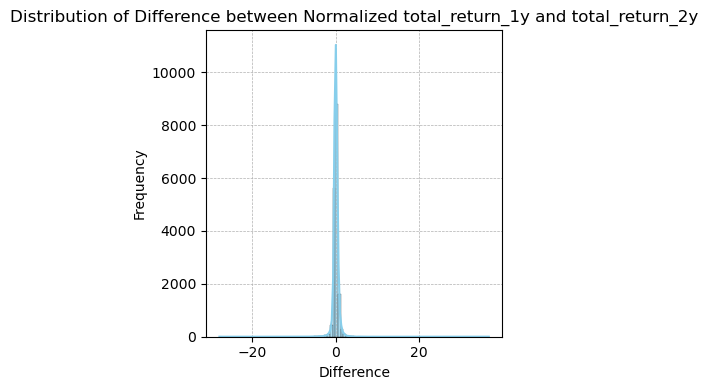

Correlation between total_return_1y and total_return_2y: 0.507917

Mean Difference (Normalized): 0.003550
Standard Deviation (Normalized): 0.992950
95% Confidence Interval (Normalized): (-0.011271, 0.018372)


In [8]:
normalized_difference(df, 'total_return_1y', 'total_return_2y')

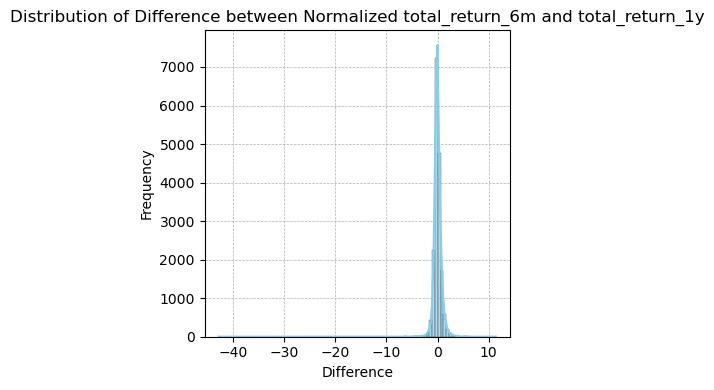

Correlation between total_return_6m and total_return_1y: 0.548832

Mean Difference (Normalized): -0.000039
Standard Deviation (Normalized): 0.948460
95% Confidence Interval (Normalized): (-0.014018, 0.013941)


In [9]:
normalized_difference(df, 'total_return_6m', 'total_return_1y')

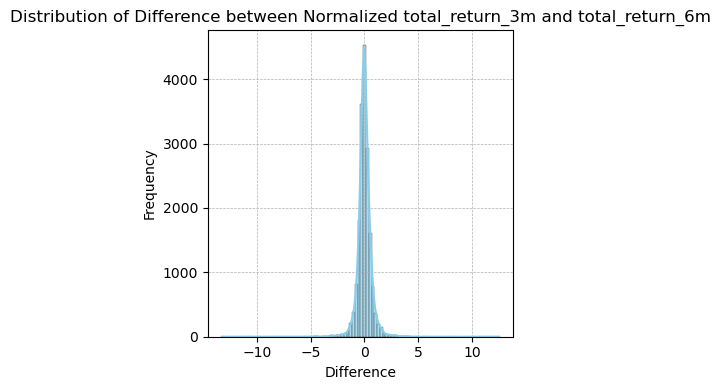

Correlation between total_return_3m and total_return_6m: 0.756237

Mean Difference (Normalized): -0.001724
Standard Deviation (Normalized): 0.696888
95% Confidence Interval (Normalized): (-0.011924, 0.008475)


In [10]:
normalized_difference(df, 'total_return_3m', 'total_return_6m')

## 1.4 Substitution

According to the results above, the neighbouring values show a good proof of interchangability. 

Therefore, when the value of **total_return_(X)y_normalized** is missing, we substitute with **total_return_(X-1)y_normalized**, as shown below.

In [11]:
df['total_return_5y_normalized'] = np.where(df['total_return_5y_normalized'].isna() & df['total_return_4y_normalized'].notna(), df['total_return_4y_normalized'], df['total_return_5y_normalized'])
df['total_return_4y_normalized'] = np.where(df['total_return_4y_normalized'].isna() & df['total_return_3y_normalized'].notna(), df['total_return_3y_normalized'], df['total_return_4y_normalized'])
df['total_return_3y_normalized'] = np.where(df['total_return_3y_normalized'].isna() & df['total_return_2y_normalized'].notna(), df['total_return_2y_normalized'], df['total_return_3y_normalized'])
df['total_return_2y_normalized'] = np.where(df['total_return_2y_normalized'].isna() & df['total_return_1y_normalized'].notna(), df['total_return_1y_normalized'], df['total_return_2y_normalized'])
df['total_return_1y_normalized'] = np.where(df['total_return_1y_normalized'].isna() & df['total_return_6m_normalized'].notna(), df['total_return_6m_normalized'], df['total_return_1y_normalized'])
df['total_return_6m_normalized'] = np.where(df['total_return_6m_normalized'].isna() & df['total_return_3m_normalized'].notna(), df['total_return_3m_normalized'], df['total_return_6m_normalized'])

Then, we denormalize those values and map it back to the original columns:

In [12]:
mean_5y = df['total_return_5y'].mean()
std_5y = df['total_return_5y'].std()

mean_4y = df['total_return_4y'].mean()
std_4y = df['total_return_4y'].std()

mean_3y = df['total_return_3y'].mean()
std_3y = df['total_return_3y'].std()

mean_2y = df['total_return_2y'].mean()
std_2y = df['total_return_2y'].std()

mean_1y = df['total_return_1y'].mean()
std_1y = df['total_return_1y'].std()

mean_6m = df['total_return_6m'].mean()
std_6m = df['total_return_6m'].std()

mean_3m = df['total_return_3m'].mean()
std_3m = df['total_return_3m'].std()

mask_5y = (df['total_return_5y'].isna() & df['total_return_4y'].notna())
df.loc[mask_5y, 'total_return_5y'] = (df['total_return_5y_normalized'] * std_5y) + mean_5y

mask_4y = (df['total_return_4y'].isna() & df['total_return_3y'].notna())
df.loc[mask_4y, 'total_return_4y'] = (df['total_return_4y_normalized'] * std_4y) + mean_4y

mask_3y = (df['total_return_3y'].isna() & df['total_return_2y'].notna())
df.loc[mask_3y, 'total_return_3y'] = (df['total_return_3y_normalized'] * std_3y) + mean_3y

mask_2y = (df['total_return_2y'].isna() & df['total_return_1y'].notna())
df.loc[mask_2y, 'total_return_2y'] = (df['total_return_2y_normalized'] * std_2y) + mean_2y

mask_1y = (df['total_return_1y'].isna() & df['total_return_6m'].notna())
df.loc[mask_2y, 'total_return_1y'] = (df['total_return_1y_normalized'] * std_2y) + mean_2y

mask_6m = (df['total_return_6m'].isna() & df['total_return_3m'].notna())
df.loc[mask_6m, 'total_return_6m'] = (df['total_return_6m_normalized'] * std_6m) + mean_6m

# 2. capex & net_capex

There are two variables related to capital expenditure
- capex：capital expenditure: cash used for the acquistion of assets like property, plant and equipment
- net_capex: capex - proceeds from the sale of long-term assets

## 2.1 check colinearity

1. Correlation matrix


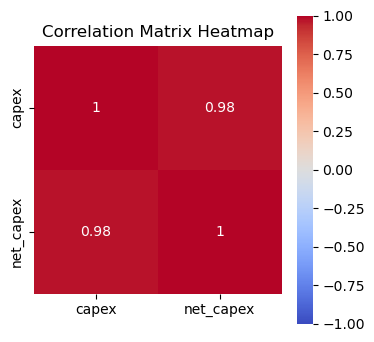


2. Eigenvalues: [1.9763111 0.0236889]

3. Condition Number: 9.133877099066106

4. VIF:
    Variable        VIF
0      capex  21.359924
1  net_capex  21.359924
2      const   1.058887

--------------------------------------------------



In [13]:
# Analyzing 'capex' and 'net_capex' columns
cols = ['capex', 'net_capex']
analyze_columns(df, cols)

To conclude:
1. It has a extremely high correlation (0.98)
2. Eigenvalues are pretty small, especially the second eigenvalue is 0.02
3. Condition number is 9, which is pretty big
4. VIF values for all the variables is 21, which is very hight.

Therefore, we may decide to drop one of the 2 columns.
Also, I did a basic visualization to check the correlation. 

df has columns 'capex' and 'net_capex'. Plot a dot plot with capex on the x-axis and net_capex on the y-axis

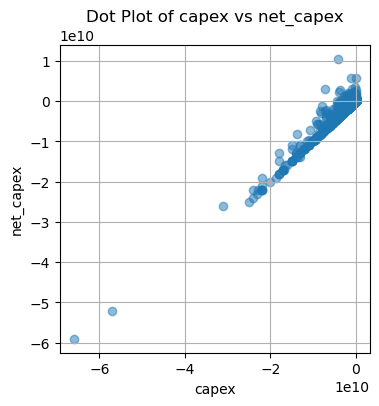

In [14]:
# Scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(df['capex'], df['net_capex'], alpha=0.5)
plt.title('Dot Plot of capex vs net_capex')
plt.xlabel('capex')
plt.ylabel('net_capex')
plt.grid(True)
plt.show()

## 2.2 Missing values counting

In [15]:
total_rows = len(df)
capex_na_count = df['capex'].isna().sum()
net_capex_na_count = df['net_capex'].isna().sum()
both_not_missing = df.dropna(subset=['capex', 'net_capex']).shape[0]
only_net_capex_missing = df[df['capex'].notna() & df['net_capex'].isna()].shape[0]
only_capex_missing = df[df['capex'].isna() & df['net_capex'].notna()].shape[0]
both_missing = df[df['capex'].isna() & df['net_capex'].isna()].shape[0]
print(f"Number of rows where capex is missing: {capex_na_count}")
print(f"Number of rows where net_capex is missing: {net_capex_na_count}")
print(f"Number of rows where both are not missing: {both_not_missing}")
print(f"Number of rows where only net_capex is missing: {only_net_capex_missing}")
print(f"Number of rows where only capex is missing: {only_capex_missing}")
print(f"Number of rows where both are missing: {both_missing}")

Number of rows where capex is missing: 781
Number of rows where net_capex is missing: 1218
Number of rows where both are not missing: 16986
Number of rows where only net_capex is missing: 446
Number of rows where only capex is missing: 9
Number of rows where both are missing: 772


## 2.3. Check Interchangability

net_capex = capex - proceeds from the sale of long-term assets.

Semantically, they are equal most of the times as the sales of long-term assets rarely happen. However, the difference betweem the two could be significant if the long-term asset sales occur. 

Statistically, the distribution of difference of the normalized values of 2 columns is shown below:

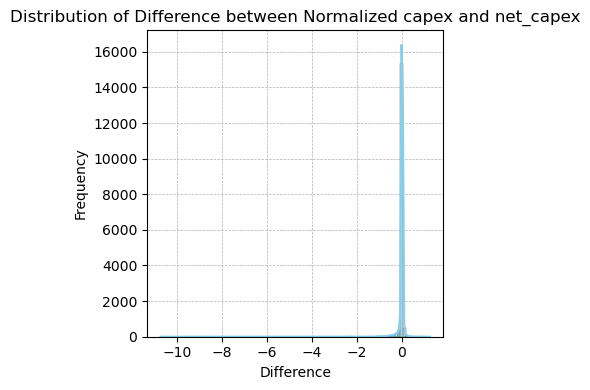

Correlation between capex and net_capex: 0.976311

Mean Difference (Normalized): -0.002569
Standard Deviation (Normalized): 0.218977
95% Confidence Interval (Normalized): (-0.005862, 0.000725)


In [16]:
normalized_difference(df, 'capex', 'net_capex')

## 2.4 Substitution

Although some extreme values happen sometimes, we could see the difference is close to zero, with an acceptable range of standard deviation. 

Therefore, when exactly one of these values are missing, we substitute with the value of the other, as shown below.

In [17]:
df['capex_normalized'] = np.where(df['capex_normalized'].isna() & ~df['net_capex_normalized'].isna(), df['net_capex_normalized'], df['capex_normalized'])
df['net_capex_normalized'] = np.where(df['net_capex_normalized'].isna() & ~df['capex_normalized'].isna(), df['capex_normalized'], df['net_capex_normalized'])

In [18]:
mean_capex = df['capex'].mean()
std_capex = df['capex'].std()
mean_net_capex = df['net_capex'].mean()
std_net_capex = df['net_capex'].std()

mask_capex = (df['capex'].isna() & ~df['net_capex'].isna())
df.loc[mask_capex, 'capex'] = (df['capex_normalized'] * std_capex) + mean_capex
mask_net_capex = (df['net_capex'].isna() & ~df['capex'].isna())
df.loc[mask_net_capex, 'net_capex'] = (df['net_capex_normalized'] * std_net_capex) + mean_net_capex

## 3. Working capital

There are 3 types of working capital:
- **short_term_wc**: current assets - current liabilities
- **long_term_wc**: non-current assets - non-current liabilities
- **modified_wc**: inventories + account payable - account receivable

What's missing in modified_wc:
- Cash and cash equivalents
- Short-term investments
- Any other current assets not explicitly listed (prepaid expenses, etc.)
- Short-term debt
- Other current liabilities not explicitly listed

We conduct the same analysis as shown below:

## 3.1 check colinearity

1. Correlation matrix


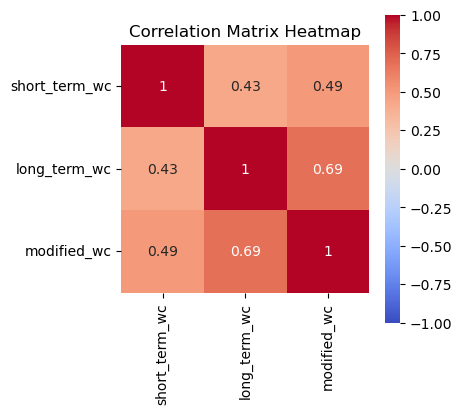


2. Eigenvalues: [2.07765919 0.61334373 0.30899709]

3. Condition Number: 2.5930444489980213

4. VIF:
        Variable       VIF
0  short_term_wc  1.347817
1   long_term_wc  1.921112
2    modified_wc  2.079065
3          const  1.085875

--------------------------------------------------



In [19]:
cols = ['short_term_wc', 'long_term_wc','modified_wc']
analyze_columns(df, cols)

According to the results above:
1. There is a meaningful correlation among them, especially the one of **long_term_wc** and **modified_wc**, which is 0.69.
2. Eigenvalues are moderately small, but both the condition number and VIFs are in the acceptable level. 

Therefore, there is no enough evidence to drop a single one among them. 

## 3.2 Missing values counting

In [20]:
total_rows = len(df)
short_term_missing = df['short_term_wc'].isna().sum()
short_term_percentage = (short_term_missing / total_rows) * 100
long_term_missing = df['long_term_wc'].isna().sum()
long_term_percentage = (long_term_missing / total_rows) * 100
modified_missing = df['modified_wc'].isna().sum()
modified_percentage = (modified_missing / total_rows) * 100
only_short_term_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].notna() & df['modified_wc'].notna()].shape[0]
only_short_term_percentage = (only_short_term_missing / total_rows) * 100
only_long_term_missing = df[df['short_term_wc'].notna() & df['long_term_wc'].isna() & df['modified_wc'].notna()].shape[0]
only_long_term_percentage = (only_long_term_missing / total_rows) * 100
only_modified_missing = df[df['short_term_wc'].notna() & df['long_term_wc'].notna() & df['modified_wc'].isna()].shape[0]
only_modified_percentage = (only_modified_missing / total_rows) * 100
short_and_long_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].isna() & df['modified_wc'].notna()].shape[0]
short_and_long_percentage = (short_and_long_missing / total_rows) * 100
short_and_modified_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].notna() & df['modified_wc'].isna()].shape[0]
short_and_modified_percentage = (short_and_modified_missing / total_rows) * 100
long_and_modified_missing = df[df['short_term_wc'].notna() & df['long_term_wc'].isna() & df['modified_wc'].isna()].shape[0]
long_and_modified_percentage = (long_and_modified_missing / total_rows) * 100
all_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].isna() & df['modified_wc'].isna()].shape[0]
all_missing_percentage = (all_missing / total_rows) * 100
print(f"Rows where 'short_term_wc' is missing: {short_term_missing} ({short_term_percentage:.2f}%)")
print(f"Rows where 'long_term_wc' is missing: {long_term_missing} ({long_term_percentage:.2f}%)")
print(f"Rows where 'modified_wc' is missing: {modified_missing} ({modified_percentage:.2f}%)")
print("")
print(f"Rows where only 'short_term_wc' is missing: {only_short_term_missing} ({only_short_term_percentage:.2f}%)")
print(f"Rows where only 'long_term_wc' is missing: {only_long_term_missing} ({only_long_term_percentage:.2f}%)")
print(f"Rows where only 'modified_wc' is missing: {only_modified_missing} ({only_modified_percentage:.2f}%)")
print(f"Rows where only 'short_term_wc' and 'long_term_wc' are missing: {short_and_long_missing} ({short_and_long_percentage:.2f}%)")
print(f"Rows where only 'short_term_wc' and 'modified_wc' are missing: {short_and_modified_missing} ({short_and_modified_percentage:.2f}%)")
print(f"Rows where only 'long_term_wc' and 'modified_wc' are missing: {long_and_modified_missing} ({long_and_modified_percentage:.2f}%)")
print(f"Rows where all of them are missing: {all_missing} ({all_missing_percentage:.2f}%)")


Rows where 'short_term_wc' is missing: 5475 (30.06%)
Rows where 'long_term_wc' is missing: 4655 (25.56%)
Rows where 'modified_wc' is missing: 4293 (23.57%)

Rows where only 'short_term_wc' is missing: 805 (4.42%)
Rows where only 'long_term_wc' is missing: 0 (0.00%)
Rows where only 'modified_wc' is missing: 20 (0.11%)
Rows where only 'short_term_wc' and 'long_term_wc' are missing: 397 (2.18%)
Rows where only 'short_term_wc' and 'modified_wc' are missing: 15 (0.08%)
Rows where only 'long_term_wc' and 'modified_wc' are missing: 0 (0.00%)
Rows where all of them are missing: 4258 (23.38%)


As shown:
1. Most of the missing data come from the same rows (4258 rows, 23.38%), therefore, substitution doesn't seem appropriate among these 3 fields for these rows. 
2. There is a significant amount of portion where **short_term_wc** is alone missing (805 rows, 4.42%). We check whether substitution is available for these rows.  

## 3.3 Check interchangability

### 3.3.1 short_term_wc & long_term_wc

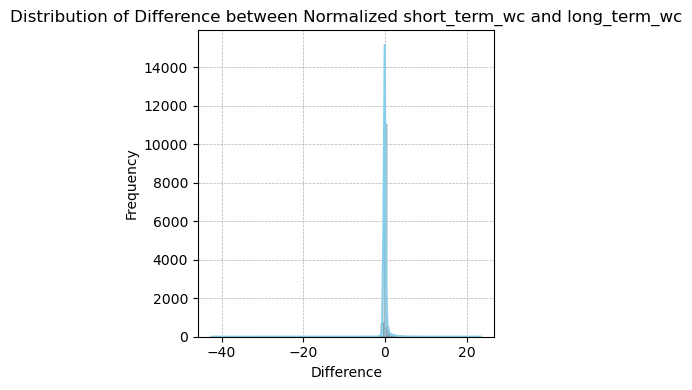

Correlation between short_term_wc and long_term_wc: 0.425840

Mean Difference (Normalized): -0.003983
Standard Deviation (Normalized): 1.082611
95% Confidence Interval (Normalized): (-0.022786, 0.014819)


In [21]:
normalized_difference(df, 'short_term_wc', 'long_term_wc')

### 3.3.2 short_term_wc & modified_wc

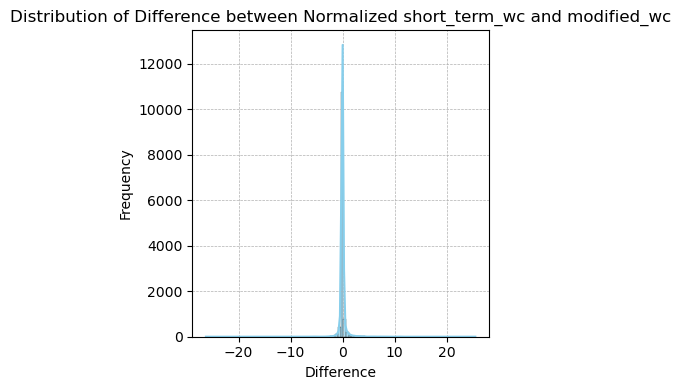

Correlation between short_term_wc and modified_wc: 0.493499

Mean Difference (Normalized): -0.005270
Standard Deviation (Normalized): 1.006923
95% Confidence Interval (Normalized): (-0.022771, 0.012232)


In [22]:
normalized_difference(df, 'short_term_wc', 'modified_wc')

### 3.3.3 modified_wc & long_term_wc

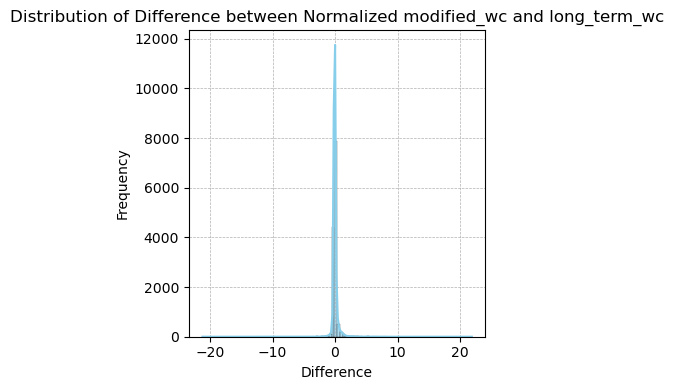

Correlation between modified_wc and long_term_wc: 0.670991

Mean Difference (Normalized): 0.001779
Standard Deviation (Normalized): 0.816759
95% Confidence Interval (Normalized): (-0.011988, 0.015547)


In [23]:
normalized_difference(df, 'modified_wc', 'long_term_wc')

## 3.4 Substitution

Most of them showed high standard deviation in general. Therefore, we decide not to do the substitution in this case.

# 4. ebit, ebitda, net_income, net_revenue

- EBIT = Revenue - Operating Expenses
- EBITDA = EBIT + Depreciation + Amortization
- net income =  EBIT - Interest - taxes

## 4.1 colinearity test

1. Correlation matrix


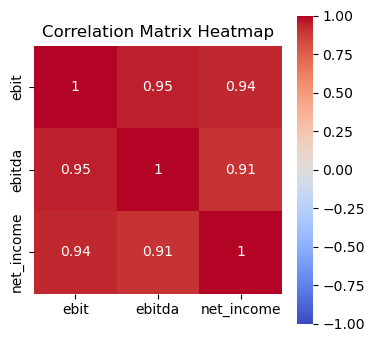


2. Eigenvalues: [2.86145759 0.0422942  0.09624821]

3. Condition Number: 8.225328046511585

4. VIF:
     Variable        VIF
0        ebit  15.518488
1      ebitda  10.632150
2  net_income   8.232539
3       const   1.084020

--------------------------------------------------



In [24]:
cols = ['ebit', 'ebitda','net_income']
analyze_columns(df, cols)

As shown above:
1. There are extremely high correlations among ebitda, ebit, and net_income (~0.9)
1. Eigenvalues are small and condition number is big. Indicate a high colinearity.
1. Extremely high VIFs for ebit, ebitda, and net_income giving another proof of high colinearity among them

## 4.2 Missing value checking

In [25]:
total_rows = len(df)

ebit_missing = df['ebit'].isna().sum()
ebit_percentage = (ebit_missing / total_rows) * 100
ebitda_missing = df['ebitda'].isna().sum()
ebitda_percentage = (ebitda_missing / total_rows) * 100
net_income_missing = df['net_income'].isna().sum()
net_income_percentage = (net_income_missing / total_rows) * 100

only_ebit_missing = df[df['ebit'].isna() & df['ebitda'].notna() & df['net_income'].notna()].shape[0]
only_ebit_percentage = (only_ebit_missing / total_rows) * 100
only_ebitda_missing = df[df['ebit'].notna() & df['ebitda'].isna() & df['net_income'].notna()].shape[0]
only_ebitda_percentage = (only_ebitda_missing / total_rows) * 100
only_net_income_missing = df[df['ebit'].notna() & df['ebitda'].notna() & df['net_income'].isna()].shape[0]
only_net_income_percentage = (only_net_income_missing / total_rows) * 100

ebit_and_ebitda_missing = df[df['ebit'].isna() & df['ebitda'].isna() & df['net_income'].notna()].shape[0]
ebit_and_ebitda_percentage = (ebit_and_ebitda_missing / total_rows) * 100
ebit_and_net_income_missing = df[df['ebit'].isna() & df['ebitda'].notna() & df['net_income'].isna()].shape[0]
ebit_and_net_income_percentage = (ebit_and_net_income_missing / total_rows) * 100
ebitda_and_net_income_missing = df[df['ebit'].notna() & df['ebitda'].isna() & df['net_income'].isna()].shape[0]
ebitda_and_net_income_percentage = (ebitda_and_net_income_missing / total_rows) * 100

all_missing = df[df['ebit'].isna() & df['ebitda'].isna() & df['net_income'].isna()].shape[0]
all_missing_percentage = (all_missing / total_rows) * 100

print(f"Rows where 'ebit' is missing: {ebit_missing} ({ebit_percentage:.2f}%)")
print(f"Rows where 'ebitda' is missing: {ebitda_missing} ({ebitda_percentage:.2f}%)")
print(f"Rows where 'net_income' is missing: {net_income_missing} ({net_income_percentage:.2f}%)")
print("")
print(f"Rows where only 'ebit' is missing: {only_ebit_missing} ({only_ebit_percentage:.2f}%)")
print(f"Rows where only 'ebitda' is missing: {only_ebitda_missing} ({only_ebitda_percentage:.2f}%)")
print(f"Rows where only 'net_income' is missing: {only_net_income_missing} ({only_net_income_percentage:.2f}%)")
print("")
print(f"Rows where only 'ebit' and 'ebitda' are missing: {ebit_and_ebitda_missing} ({ebit_and_ebitda_percentage:.2f}%)")
print(f"Rows where only 'ebit' and 'net_income' are missing: {ebit_and_net_income_missing} ({ebit_and_net_income_percentage:.2f}%)")
print(f"Rows where only 'ebitda' and 'net_income' are missing: {ebitda_and_net_income_missing} ({ebitda_and_net_income_percentage:.2f}%)")
print("")
print(f"Rows where all of them are missing: {all_missing} ({all_missing_percentage:.2f}%)")


Rows where 'ebit' is missing: 2108 (11.57%)
Rows where 'ebitda' is missing: 2919 (16.03%)
Rows where 'net_income' is missing: 242 (1.33%)

Rows where only 'ebit' is missing: 6 (0.03%)
Rows where only 'ebitda' is missing: 803 (4.41%)
Rows where only 'net_income' is missing: 43 (0.24%)

Rows where only 'ebit' and 'ebitda' are missing: 1920 (10.54%)
Rows where only 'ebit' and 'net_income' are missing: 3 (0.02%)
Rows where only 'ebitda' and 'net_income' are missing: 17 (0.09%)

Rows where all of them are missing: 179 (0.98%)


According to the result above:
1. While most of the net_income value are not missing, the values of ebit an ebitda are missing for more than 10%.
2. There are only 6 rows where ebit alone is missing, while there are about 800 rows where only ebitda is missing. 

## 4.3. Check interchangability

### 4.3.1 ebitda & ebit

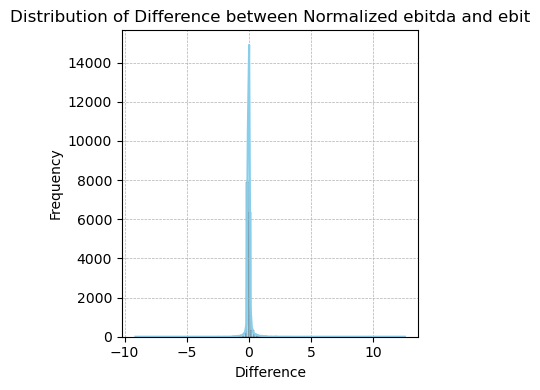

Correlation between ebitda and ebit: 0.950851

Mean Difference (Normalized): 0.002610
Standard Deviation (Normalized): 0.316123
95% Confidence Interval (Normalized): (-0.002402, 0.007622)


In [26]:
normalized_difference(df, 'ebitda', 'ebit')

### 4.3.2 ebitda & net_income

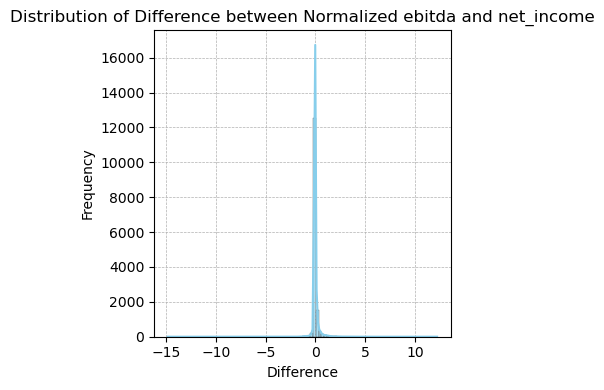

Correlation between ebitda and net_income: 0.905118

Mean Difference (Normalized): 0.009575
Standard Deviation (Normalized): 0.428589
95% Confidence Interval (Normalized): (0.002771, 0.016378)


In [27]:
normalized_difference(df, 'ebitda', 'net_income')

### 4.3.3 ebit & net_income

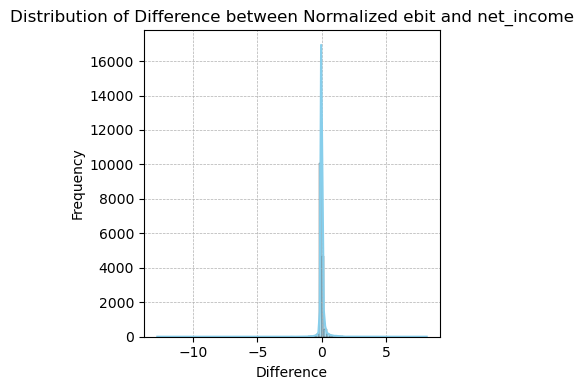

Correlation between ebit and net_income: 0.935167

Mean Difference (Normalized): 0.007315
Standard Deviation (Normalized): 0.354871
95% Confidence Interval (Normalized): (0.001824, 0.012806)


In [28]:
normalized_difference(df, 'ebit', 'net_income')

## 4.4 Substitution

Therefore, we decide to:
1. If net_income_normalized value is missing, put in the value of ebit_normalized.
2. If exactly one of ebit_normalized and ebitda_normalized are missing, fill the missing value of a column with the one of the other column.


In [29]:
df['net_income_normalized'].fillna(df['ebit_normalized'], inplace=True)

df['ebit_normalized'] = np.where(df['ebit_normalized'].isna() & ~df['ebitda_normalized'].isna(), df['ebitda_normalized'], df['ebit_normalized'])
df['ebitda_normalized'] = np.where(df['ebitda_normalized'].isna() & ~df['ebit_normalized'].isna(), df['ebit_normalized'], df['ebitda_normalized'])

In [30]:
mean_net_income = df['net_income'].mean()
std_net_income = df['net_income'].std()
mean_ebit = df['ebit'].mean()
std_ebit = df['ebit'].std()
mean_ebitda = df['ebitda'].mean()
std_ebitda = df['ebitda'].std()

# Identify rows where substitution took place for 'net_income_normalized' and de-normalize
mask_net_income = df['net_income'].isna()
df.loc[mask_net_income, 'net_income'] = (df['net_income_normalized'] * std_net_income) + mean_net_income

# Identify rows where substitution took place for 'ebit_normalized' and de-normalize
mask_ebit = (df['ebit'].isna() & ~df['ebitda'].isna())
df.loc[mask_ebit, 'ebit'] = (df['ebit_normalized'] * std_ebit) + mean_ebit

# Identify rows where substitution took place for 'ebitda_normalized' and de-normalize
mask_ebitda = (df['ebitda'].isna() & ~df['ebit'].isna())
df.loc[mask_ebitda, 'ebitda'] = (df['ebitda_normalized'] * std_ebitda) + mean_ebitda


# 5. ebitda_margin, operating_margin

- ebitda_margin = ebitda / net_revenue
- operating_maring = ebit / net_revenue

## 5.1. check colinearity

1. Correlation matrix


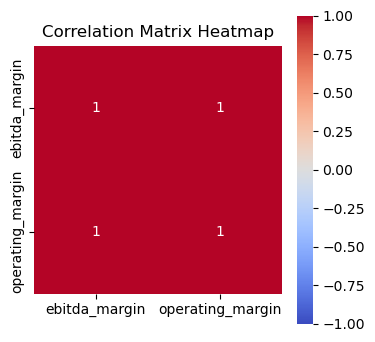


2. Eigenvalues: [1.99879814e+00 1.20185909e-03]

3. Condition Number: 40.78098325486438

4. VIF:
           Variable         VIF
0     ebitda_margin  416.272299
1  operating_margin  416.272299
2             const    1.001490

--------------------------------------------------



In [31]:
cols = ['ebitda_margin', 'operating_margin']
analyze_columns(df, cols)

According the result above, **ebitda_margin** and **operating_margin** has an extremely high correlation

## 5.2 Counting missing values

In [32]:
total_rows = len(df)

ebitda_margin_missing = df['ebitda_margin'].isna().sum()
ebitda_margin_percentage = (ebitda_margin_missing / total_rows) * 100
operating_margin_missing = df['operating_margin'].isna().sum()
operating_margin_percentage = (operating_margin_missing / total_rows) * 100

only_ebitda_margin_missing = df[df['ebitda_margin'].isna() & df['operating_margin'].notna()].shape[0]
only_ebitda_margin_percentage = (only_ebitda_margin_missing / total_rows) * 100
only_operating_margin_missing = df[df['ebitda_margin'].notna() & df['operating_margin'].isna()].shape[0]
only_operating_margin_percentage = (only_operating_margin_missing / total_rows) * 100
both_missing = df[df['ebitda_margin'].isna() & df['operating_margin'].isna()].shape[0]
both_missing_percentage = (both_missing / total_rows) * 100

print(f"Rows where 'ebitda_margin' is missing: {ebitda_margin_missing} ({ebitda_margin_percentage:.2f}%)")
print(f"Rows where 'operating_margin' is missing: {operating_margin_missing} ({operating_margin_percentage:.2f}%)")
print(f"Rows where only 'ebitda_margin' is missing: {only_ebitda_margin_missing} ({only_ebitda_margin_percentage:.2f}%)")
print(f"Rows where only 'operating_margin' is missing: {only_operating_margin_missing} ({only_operating_margin_percentage:.2f}%)")
print(f"Rows where both of them are missing: {both_missing} ({both_missing_percentage:.2f}%)")

Rows where 'ebitda_margin' is missing: 3618 (19.86%)
Rows where 'operating_margin' is missing: 860 (4.72%)
Rows where only 'ebitda_margin' is missing: 2773 (15.23%)
Rows where only 'operating_margin' is missing: 15 (0.08%)
Rows where both of them are missing: 845 (4.64%)


## 5.3. Check interchangability

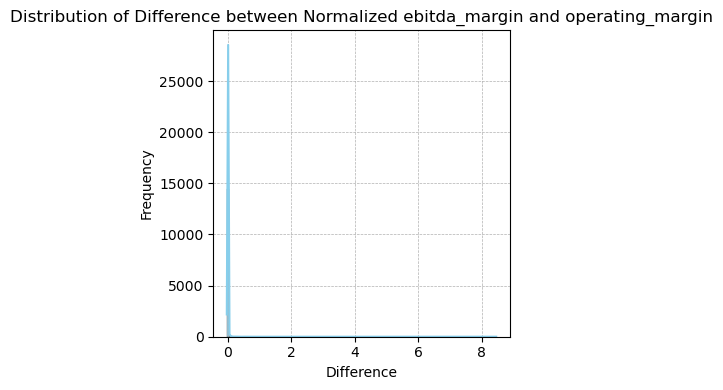

Correlation between ebitda_margin and operating_margin: 0.998798

Mean Difference (Normalized): 0.004635
Standard Deviation (Normalized): 0.103048
95% Confidence Interval (Normalized): (0.002963, 0.006308)


In [33]:
normalized_difference(df, 'ebitda_margin', 'operating_margin')

## 5.4. Substitution

As the mean difference is close to zero and the standard deviation is very low, we decide to conduct the substitution

In [34]:
mask_ebitda_margin_missing = df['ebitda_margin_normalized'].isna() & df['operating_margin_normalized'].notna()
df.loc[mask_ebitda_margin_missing, 'ebitda_margin_normalized'] = df.loc[mask_ebitda_margin_missing, 'operating_margin_normalized']
mask_operating_margin_missing = df['operating_margin_normalized'].isna() & df['ebitda_margin_normalized'].notna()
df.loc[mask_operating_margin_missing, 'operating_margin_normalized'] = df.loc[mask_operating_margin_missing, 'ebitda_margin_normalized']

In [35]:
mean_ebitda_margin = df['ebitda_margin'].mean()
std_ebitda_margin = df['ebitda_margin'].std()

mean_operating_margin = df['operating_margin'].mean()
std_operating_margin = df['operating_margin'].std()

mask_ebitda_margin = (df['ebitda_margin'].isna() & df['operating_margin'].notna())
df.loc[mask_ebitda_margin, 'ebitda_margin'] = (df['ebitda_margin_normalized'] * std_ebitda_margin) + mean_ebitda_margin

mask_operating_margin = (df['operating_margin'].isna() & df['ebitda_margin'].notna())
df.loc[mask_operating_margin, 'operating_margin'] = (df['operating_margin_normalized'] * std_operating_margin) + mean_operating_margin


# 6. rsi_14d, rsi_30d

## 6.1. check colinearity

1. Correlation matrix


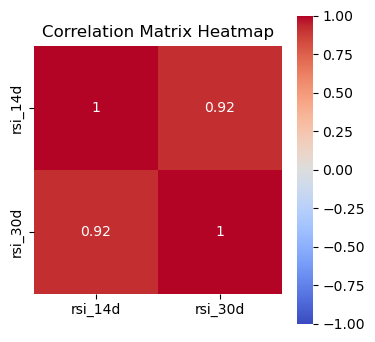


2. Eigenvalues: [1.91697623 0.08302377]

3. Condition Number: 4.805152090036216

4. VIF:
  Variable        VIF
0  rsi_14d   6.283199
1  rsi_30d   6.283199
2    const  38.714201

--------------------------------------------------



In [36]:
cols = ['rsi_14d', 'rsi_30d']
analyze_columns(df, cols)

We could see that **rsi_14d** and **rsi_30d** are highly correlated to each other (0.92)

## 6.2. Check missing values

In [37]:
total_rows = len(df)

rsi_14d_missing = df['rsi_14d'].isna().sum()
rsi_14d_percentage = (rsi_14d_missing / total_rows) * 100
rsi_30d_missing = df['rsi_30d'].isna().sum()
rsi_30d_percentage = (rsi_30d_missing / total_rows) * 100

only_rsi_14d_missing = df[df['rsi_14d'].isna() & df['rsi_30d'].notna()].shape[0]
only_rsi_14d_percentage = (only_rsi_14d_missing / total_rows) * 100
only_rsi_30d_missing = df[df['rsi_14d'].notna() & df['rsi_30d'].isna()].shape[0]
only_rsi_30d_percentage = (only_rsi_30d_missing / total_rows) * 100
both_missing_rsi = df[df['rsi_14d'].isna() & df['rsi_30d'].isna()].shape[0]
both_missing_rsi_percentage = (both_missing_rsi / total_rows) * 100

print(f"Rows where 'rsi_14d' is missing: {rsi_14d_missing} ({rsi_14d_percentage:.2f}%)")
print(f"Rows where 'rsi_30d' is missing: {rsi_30d_missing} ({rsi_30d_percentage:.2f}%)")
print(f"Rows where only 'rsi_14d' is missing: {only_rsi_14d_missing} ({only_rsi_14d_percentage:.2f}%)")
print(f"Rows where only 'rsi_30d' is missing: {only_rsi_30d_missing} ({only_rsi_30d_percentage:.2f}%)")
print(f"Rows where both of them are missing: {both_missing_rsi} ({both_missing_rsi_percentage:.2f}%)")

Rows where 'rsi_14d' is missing: 90 (0.49%)
Rows where 'rsi_30d' is missing: 103 (0.57%)
Rows where only 'rsi_14d' is missing: 0 (0.00%)
Rows where only 'rsi_30d' is missing: 13 (0.07%)
Rows where both of them are missing: 90 (0.49%)


## 6.3 Check interchangability

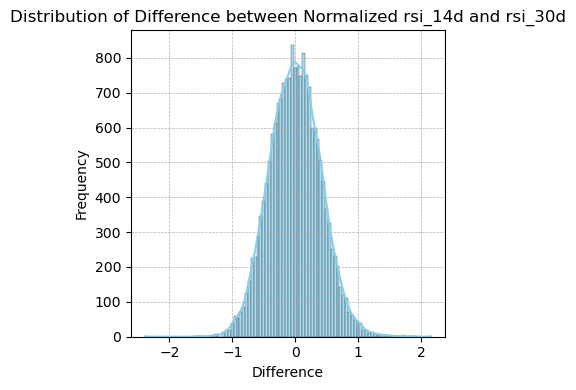

Correlation between rsi_14d and rsi_30d: 0.916976

Mean Difference (Normalized): 0.000511
Standard Deviation (Normalized): 0.407448
95% Confidence Interval (Normalized): (-0.005423, 0.006446)


In [38]:
normalized_difference(df, 'rsi_14d', 'rsi_30d')

## 6.4 Substitution

As the mean difference is close to zero and the standard deviation is acceptably low, We interchange the values between the normalized values of the two.

In [39]:
mask_rsi_14d_missing = df['rsi_14d_normalized'].isna() & df['rsi_30d_normalized'].notna()
df.loc[mask_rsi_14d_missing, 'rsi_14d_normalized'] = df.loc[mask_rsi_14d_missing, 'rsi_30d_normalized']
mask_rsi_30d_missing = df['rsi_30d_normalized'].isna() & df['rsi_14d_normalized'].notna()
df.loc[mask_rsi_30d_missing, 'rsi_30d_normalized'] = df.loc[mask_rsi_30d_missing, 'rsi_14d_normalized']

In [40]:
mean_rsi_14d = df['rsi_14d'].mean()
std_rsi_14d = df['rsi_14d'].std()
mean_rsi_30d = df['rsi_30d'].mean()
std_rsi_30d = df['rsi_30d'].std()

mask_rsi_14d = (df['rsi_14d'].isna() & df['rsi_30d'].notna())
df.loc[mask_rsi_14d, 'rsi_14d'] = (df['rsi_14d_normalized'] * std_rsi_14d) + mean_rsi_14d
mask_rsi_30d = (df['rsi_30d'].isna() & df['rsi_14d'].notna())
df.loc[mask_rsi_30d, 'rsi_30d'] = (df['rsi_30d_normalized'] * std_rsi_30d) + mean_rsi_30d

# 7. volatility_30d, volatility_90d, volatility_180d

## 7.1. check colinearity

1. Correlation matrix


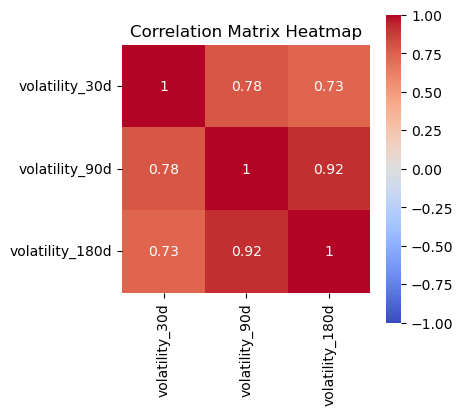


2. Eigenvalues: [2.62340913 0.29635047 0.0802404 ]

3. Condition Number: 5.717898938095609

4. VIF:
          Variable       VIF
0   volatility_30d  2.586025
1   volatility_90d  7.402796
2  volatility_180d  6.229296
3            const  3.492812

--------------------------------------------------



In [41]:
cols = ['volatility_30d', 'volatility_90d','volatility_180d']
analyze_columns(df, cols)

According to the result:
1. The correlation between volatility_90d and volatility_180d is very high (0.92)
2. The correlation between volatility_30d and volatility_90d, and the one between volatility_30d and volatility_180d is pretty high too (0.7~)

## 7.2 check missing values

In [42]:
total_rows = len(df)

volatility_30d_missing = df['volatility_30d'].isna().sum()
volatility_30d_percentage = (volatility_30d_missing / total_rows) * 100
volatility_90d_missing = df['volatility_90d'].isna().sum()
volatility_90d_percentage = (volatility_90d_missing / total_rows) * 100
volatility_180d_missing = df['volatility_180d'].isna().sum()
volatility_180d_percentage = (volatility_180d_missing / total_rows) * 100

only_volatility_30d_missing = df[df['volatility_30d'].isna() & df['volatility_90d'].notna() & df['volatility_180d'].notna()].shape[0]
only_volatility_30d_percentage = (only_volatility_30d_missing / total_rows) * 100
only_volatility_90d_missing = df[df['volatility_30d'].notna() & df['volatility_90d'].isna() & df['volatility_180d'].notna()].shape[0]
only_volatility_90d_percentage = (only_volatility_90d_missing / total_rows) * 100
only_volatility_180d_missing = df[df['volatility_30d'].notna() & df['volatility_90d'].notna() & df['volatility_180d'].isna()].shape[0]
only_volatility_180d_percentage = (only_volatility_180d_missing / total_rows) * 100

volatility_30d_and_90d_missing = df[df['volatility_30d'].isna() & df['volatility_90d'].isna() & df['volatility_180d'].notna()].shape[0]
volatility_30d_and_90d_percentage = (volatility_30d_and_90d_missing / total_rows) * 100
volatility_30d_and_180d_missing = df[df['volatility_30d'].isna() & df['volatility_90d'].notna() & df['volatility_180d'].isna()].shape[0]
volatility_30d_and_180d_percentage = (volatility_30d_and_180d_missing / total_rows) * 100
volatility_90d_and_180d_missing = df[df['volatility_30d'].notna() & df['volatility_90d'].isna() & df['volatility_180d'].isna()].shape[0]
volatility_90d_and_180d_percentage = (volatility_90d_and_180d_missing / total_rows) * 100

all_missing = df[df['volatility_30d'].isna() & df['volatility_90d'].isna() & df['volatility_180d'].isna()].shape[0]
all_missing_percentage = (all_missing / total_rows) * 100

print(f"Rows where 'volatility_30d' is missing: {volatility_30d_missing} ({volatility_30d_percentage:.2f}%)")
print(f"Rows where 'volatility_90d' is missing: {volatility_90d_missing} ({volatility_90d_percentage:.2f}%)")
print(f"Rows where 'volatility_180d' is missing: {volatility_180d_missing} ({volatility_180d_percentage:.2f}%)")
print("")
print(f"Rows where only 'volatility_30d' is missing: {only_volatility_30d_missing} ({only_volatility_30d_percentage:.2f}%)")
print(f"Rows where only 'volatility_90d' is missing: {only_volatility_90d_missing} ({only_volatility_90d_percentage:.2f}%)")
print(f"Rows where only 'volatility_180d' is missing: {only_volatility_180d_missing} ({only_volatility_180d_percentage:.2f}%)")
print("")
print(f"Rows where only 'volatility_30d' and 'volatility_90d' are missing: {volatility_30d_and_90d_missing} ({volatility_30d_and_90d_percentage:.2f}%)")
print(f"Rows where only 'volatility_30d' and 'volatility_180d' are missing: {volatility_30d_and_180d_missing} ({volatility_30d_and_180d_percentage:.2f}%)")
print(f"Rows where only 'volatility_90d' and 'volatility_180d' are missing: {volatility_90d_and_180d_missing} ({volatility_90d_and_180d_percentage:.2f}%)")
print("")
print(f"Rows where all of them are missing: {all_missing} ({all_missing_percentage:.2f}%)")


Rows where 'volatility_30d' is missing: 81 (0.44%)
Rows where 'volatility_90d' is missing: 81 (0.44%)
Rows where 'volatility_180d' is missing: 81 (0.44%)

Rows where only 'volatility_30d' is missing: 0 (0.00%)
Rows where only 'volatility_90d' is missing: 0 (0.00%)
Rows where only 'volatility_180d' is missing: 0 (0.00%)

Rows where only 'volatility_30d' and 'volatility_90d' are missing: 0 (0.00%)
Rows where only 'volatility_30d' and 'volatility_180d' are missing: 0 (0.00%)
Rows where only 'volatility_90d' and 'volatility_180d' are missing: 0 (0.00%)

Rows where all of them are missing: 81 (0.44%)


As all the rows have either all the volatility values or none of the volality values, we can never proceed the substitution

# 8. normalized_roe, operating_roe (ROE not collected yet)

- operating roe = trailing 12 month operating income / (total common equity beginning balance + total common equity ending balance)/2)]*100


- normalized roe: Trailing 12 month normalized income /  average of current and prior period x 100
    - (normalized income: abnormal one-time event included: Income before extraordinary items less minority interest and less preferred dividends + abnormal/unusual/XO loss/gain, net of tax.
    
- WE NEED ROE too. To be collected soon.


## 8.1. Check colinearity

1. Correlation matrix


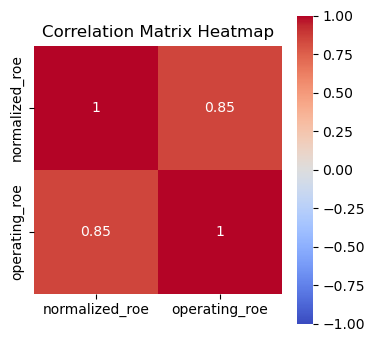


2. Eigenvalues: [1.8470664 0.1529336]

3. Condition Number: 3.4752799952149385

4. VIF:
         Variable       VIF
0  normalized_roe  3.540092
1   operating_roe  3.540092
2           const  1.019859

--------------------------------------------------



In [43]:
cols = ['normalized_roe','operating_roe']
analyze_columns(df, cols)

1. There is a high correlation between **normalized_roe** and **operating_roe** (0.85).
2. **headline_roe value** is correlated to neither **normalized-roe** or **operating_roe**.

## 8.2 check missing values

In [44]:
total_rows = len(df)

normalized_roe_missing = df['normalized_roe'].isna().sum()
normalized_roe_percentage = (normalized_roe_missing / total_rows) * 100

operating_roe_missing = df['operating_roe'].isna().sum()
operating_roe_percentage = (operating_roe_missing / total_rows) * 100

only_normalized_roe_missing = df[df['normalized_roe'].isna() & df['operating_roe'].notna()].shape[0]
only_normalized_roe_percentage = (only_normalized_roe_missing / total_rows) * 100

only_operating_roe_missing = df[df['normalized_roe'].notna() & df['operating_roe'].isna()].shape[0]
only_operating_roe_percentage = (only_operating_roe_missing / total_rows) * 100

both_missing_roe = df[df['normalized_roe'].isna() & df['operating_roe'].isna()].shape[0]
both_missing_roe_percentage = (both_missing_roe / total_rows) * 100

print(f"Rows where 'normalized_roe' is missing: {normalized_roe_missing} ({normalized_roe_percentage:.2f}%)")
print(f"Rows where 'operating_roe' is missing: {operating_roe_missing} ({operating_roe_percentage:.2f}%)")
print(f"Rows where only 'normalized_roe' is missing: {only_normalized_roe_missing} ({only_normalized_roe_percentage:.2f}%)")
print(f"Rows where only 'operating_roe' is missing: {only_operating_roe_missing} ({only_operating_roe_percentage:.2f}%)")
print(f"Rows where both of them are missing: {both_missing_roe} ({both_missing_roe_percentage:.2f}%)")


Rows where 'normalized_roe' is missing: 2084 (11.44%)
Rows where 'operating_roe' is missing: 1782 (9.78%)
Rows where only 'normalized_roe' is missing: 347 (1.91%)
Rows where only 'operating_roe' is missing: 45 (0.25%)
Rows where both of them are missing: 1737 (9.54%)


## 8.3 check interchangability

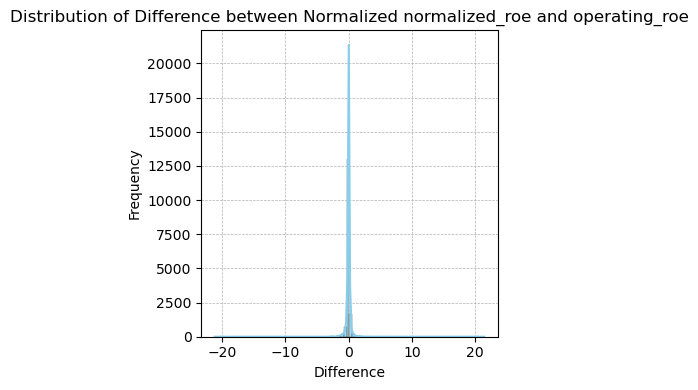

Correlation between normalized_roe and operating_roe: 0.847066

Mean Difference (Normalized): -0.008690
Standard Deviation (Normalized): 0.549789
95% Confidence Interval (Normalized): (-0.017187, -0.000192)


In [45]:
normalized_difference(df, 'normalized_roe', 'operating_roe')

The mean difference is close to zero and the standard deviation is pretty low. Therefore, we conduct the substitution between the two as shown below:

## 8.4 Substitution

In [46]:
mask_normalized_roe_missing = df['normalized_roe_normalized'].isna() & df['operating_roe_normalized'].notna()
df.loc[mask_normalized_roe_missing, 'normalized_roe_normalized'] = df.loc[mask_normalized_roe_missing, 'operating_roe_normalized']
mask_operating_roe_missing = df['operating_roe_normalized'].isna() & df['normalized_roe_normalized'].notna()
df.loc[mask_operating_roe_missing, 'operating_roe_normalized'] = df.loc[mask_operating_roe_missing, 'normalized_roe_normalized']

In [47]:
mean_normalized_roe = df['normalized_roe'].mean()
std_normalized_roe = df['normalized_roe'].std()
mean_operating_roe = df['operating_roe'].mean()
std_operating_roe = df['operating_roe'].std()

# Identify rows where substitution took place for 'normalized_roe_normalized' and de-normalize
mask_normalized_roe = (df['normalized_roe'].isna() & df['operating_roe'].notna())
df.loc[mask_normalized_roe, 'normalized_roe'] = (df['normalized_roe_normalized'] * std_normalized_roe) + mean_normalized_roe

# Identify rows where substitution took place for 'operating_roe_normalized' and de-normalize
mask_operating_roe = (df['operating_roe'].isna() & df['normalized_roe'].notna())
df.loc[mask_operating_roe, 'operating_roe'] = (df['operating_roe_normalized'] * std_operating_roe) + mean_operating_roe


# 9. eps_gaap_basic, eps_gaap_diluted, eps_adjusted_diluted

- **eps_gaap_basic**: (Net income - preferred dividends) / weighted average shares outstanding
- **eps_gaap_diluted**: (Net income - preferred dividends) / (weighted average shares outstanding + dilutive potential shares)
- **eps_adjusted_diluted**: (Adjusted net income(excluding one-time items) - preferred dividends / (weighted average shares outstanding + dilutive potential shares)


## 9.1 check colinearity

1. Correlation matrix


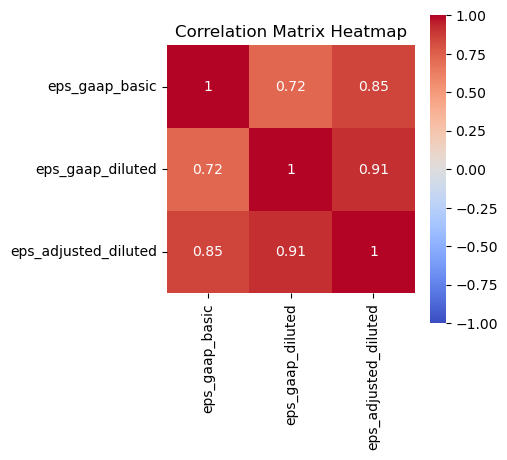


2. Eigenvalues: [2.6538753  0.28462305 0.06150165]

3. Condition Number: 6.568963616061349

4. VIF:
               Variable        VIF
0        eps_gaap_basic   3.687739
1      eps_gaap_diluted   6.133409
2  eps_adjusted_diluted  10.328804
3                 const   1.000576

--------------------------------------------------



In [48]:
cols = ['eps_gaap_basic','eps_gaap_diluted','eps_adjusted_diluted']
analyze_columns(df, cols)

## 9.2 checking missing values

In [49]:
# Calculate total rows
total_rows = len(df)

# Calculate missing values and their percentages for 'eps_gaap_basic'
eps_gaap_basic_missing = df['eps_gaap_basic'].isna().sum()
eps_gaap_basic_percentage = (eps_gaap_basic_missing / total_rows) * 100

# Calculate missing values and their percentages for 'eps_gaap_diluted'
eps_gaap_diluted_missing = df['eps_gaap_diluted'].isna().sum()
eps_gaap_diluted_percentage = (eps_gaap_diluted_missing / total_rows) * 100

# Calculate missing values and their percentages for 'eps_adjusted_diluted'
eps_adjusted_diluted_missing = df['eps_adjusted_diluted'].isna().sum()
eps_adjusted_diluted_percentage = (eps_adjusted_diluted_missing / total_rows) * 100

# Calculate rows where only one of them is missing
only_eps_gaap_basic_missing = df[df['eps_gaap_basic'].isna() & df['eps_gaap_diluted'].notna() & df['eps_adjusted_diluted'].notna()].shape[0]
only_eps_gaap_basic_percentage = (only_eps_gaap_basic_missing / total_rows) * 100
only_eps_gaap_diluted_missing = df[df['eps_gaap_basic'].notna() & df['eps_gaap_diluted'].isna() & df['eps_adjusted_diluted'].notna()].shape[0]
only_eps_gaap_diluted_percentage = (only_eps_gaap_diluted_missing / total_rows) * 100
only_eps_adjusted_diluted_missing = df[df['eps_gaap_basic'].notna() & df['eps_gaap_diluted'].notna() & df['eps_adjusted_diluted'].isna()].shape[0]
only_eps_adjusted_diluted_percentage = (only_eps_adjusted_diluted_missing / total_rows) * 100

# Calculate rows where two of them are missing
eps_gaap_basic_and_gaap_diluted_missing = df[df['eps_gaap_basic'].isna() & df['eps_gaap_diluted'].isna() & df['eps_adjusted_diluted'].notna()].shape[0]
eps_gaap_basic_and_gaap_diluted_percentage = (eps_gaap_basic_and_gaap_diluted_missing / total_rows) * 100
eps_gaap_basic_and_adjusted_diluted_missing = df[df['eps_gaap_basic'].isna() & df['eps_gaap_diluted'].notna() & df['eps_adjusted_diluted'].isna()].shape[0]
eps_gaap_basic_and_adjusted_diluted_percentage = (eps_gaap_basic_and_adjusted_diluted_missing / total_rows) * 100
eps_gaap_diluted_and_adjusted_diluted_missing = df[df['eps_gaap_basic'].notna() & df['eps_gaap_diluted'].isna() & df['eps_adjusted_diluted'].isna()].shape[0]
eps_gaap_diluted_and_adjusted_diluted_percentage = (eps_gaap_diluted_and_adjusted_diluted_missing / total_rows) * 100

# Calculate rows where all of them are missing
all_missing_eps = df[df['eps_gaap_basic'].isna() & df['eps_gaap_diluted'].isna() & df['eps_adjusted_diluted'].isna()].shape[0]
all_missing_eps_percentage = (all_missing_eps / total_rows) * 100

# Print the results
print(f"Rows where 'eps_gaap_basic' is missing: {eps_gaap_basic_missing} ({eps_gaap_basic_percentage:.2f}%)")
print(f"Rows where 'eps_gaap_diluted' is missing: {eps_gaap_diluted_missing} ({eps_gaap_diluted_percentage:.2f}%)")
print(f"Rows where 'eps_adjusted_diluted' is missing: {eps_adjusted_diluted_missing} ({eps_adjusted_diluted_percentage:.2f}%)")
print("")
print(f"Rows where only 'eps_gaap_basic' is missing: {only_eps_gaap_basic_missing} ({only_eps_gaap_basic_percentage:.2f}%)")
print(f"Rows where only 'eps_gaap_diluted' is missing: {only_eps_gaap_diluted_missing} ({only_eps_gaap_diluted_percentage:.2f}%)")
print(f"Rows where only 'eps_adjusted_diluted' is missing: {only_eps_adjusted_diluted_missing} ({only_eps_adjusted_diluted_percentage:.2f}%)")
print("")
print(f"Rows where only 'eps_gaap_basic' and 'eps_gaap_diluted' are missing: {eps_gaap_basic_and_gaap_diluted_missing} ({eps_gaap_basic_and_gaap_diluted_percentage:.2f}%)")
print(f"Rows where only 'eps_gaap_basic' and 'eps_adjusted_diluted' are missing: {eps_gaap_basic_and_adjusted_diluted_missing} ({eps_gaap_basic_and_adjusted_diluted_percentage:.2f}%)")
print(f"Rows where only 'eps_gaap_diluted' and 'eps_adjusted_diluted' are missing: {eps_gaap_diluted_and_adjusted_diluted_missing} ({eps_gaap_diluted_and_adjusted_diluted_percentage:.2f}%)")
print("")
print(f"Rows where all of them are missing: {all_missing_eps} ({all_missing_eps_percentage:.2f}%)")


Rows where 'eps_gaap_basic' is missing: 411 (2.26%)
Rows where 'eps_gaap_diluted' is missing: 413 (2.27%)
Rows where 'eps_adjusted_diluted' is missing: 358 (1.97%)

Rows where only 'eps_gaap_basic' is missing: 61 (0.33%)
Rows where only 'eps_gaap_diluted' is missing: 7 (0.04%)
Rows where only 'eps_adjusted_diluted' is missing: 0 (0.00%)

Rows where only 'eps_gaap_basic' and 'eps_gaap_diluted' are missing: 48 (0.26%)
Rows where only 'eps_gaap_basic' and 'eps_adjusted_diluted' are missing: 0 (0.00%)
Rows where only 'eps_gaap_diluted' and 'eps_adjusted_diluted' are missing: 56 (0.31%)

Rows where all of them are missing: 302 (1.66%)


In here, we decide to stick to **eps_adjusted_diluted**, as:
- Data wise, there is no rows where eps_adjusted_diluted is missing alone
- Semantically, it is the most common for the investor to take adjusted & diluted eps. 

# 10. repurchase, net_repurchase

## 10.1 check colinearity

**repurchase**: total amount of money a compnay spends on stock buyback
**net_repurchase**: amount of stock buyback - amount of shares issued or reissued

1. Correlation matrix


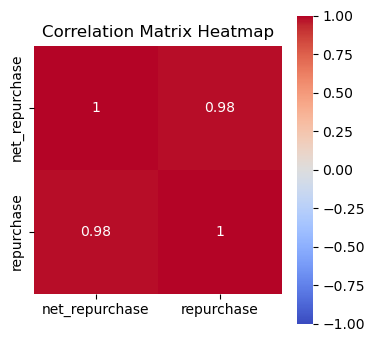


2. Eigenvalues: [1.98406046 0.01593954]

3. Condition Number: 11.156798704606818

4. VIF:
         Variable        VIF
0  net_repurchase  31.620548
1      repurchase  31.620548
2           const   1.107656

--------------------------------------------------



In [50]:
cols = ['net_repurchase', 'repurchase']
analyze_columns(df, cols)

## 10.2 check missing values

In [51]:
total_rows = len(df)

repurchase_missing = df['repurchase'].isna().sum()
repurchase_percentage = (repurchase_missing / total_rows) * 100
net_repurchase_missing = df['net_repurchase'].isna().sum()
net_repurchase_percentage = (net_repurchase_missing / total_rows) * 100

only_repurchase_missing = df[df['repurchase'].isna() & df['net_repurchase'].notna()].shape[0]
only_repurchase_percentage = (only_repurchase_missing / total_rows) * 100
only_net_repurchase_missing = df[df['repurchase'].notna() & df['net_repurchase'].isna()].shape[0]
only_net_repurchase_percentage = (only_net_repurchase_missing / total_rows) * 100
both_missing_repurchase = df[df['repurchase'].isna() & df['net_repurchase'].isna()].shape[0]
both_missing_repurchase_percentage = (both_missing_repurchase / total_rows) * 100

print(f"Rows where 'repurchase' is missing: {repurchase_missing} ({repurchase_percentage:.2f}%)")
print(f"Rows where 'net_repurchase' is missing: {net_repurchase_missing} ({net_repurchase_percentage:.2f}%)")
print(f"Rows where only 'repurchase' is missing: {only_repurchase_missing} ({only_repurchase_percentage:.2f}%)")
print(f"Rows where only 'net_repurchase' is missing: {only_net_repurchase_missing} ({only_net_repurchase_percentage:.2f}%)")
print(f"Rows where both of them are missing: {both_missing_repurchase} ({both_missing_repurchase_percentage:.2f}%)")

Rows where 'repurchase' is missing: 6782 (37.24%)
Rows where 'net_repurchase' is missing: 7980 (43.81%)
Rows where only 'repurchase' is missing: 0 (0.00%)
Rows where only 'net_repurchase' is missing: 1198 (6.58%)
Rows where both of them are missing: 6782 (37.24%)


1. There is a huge portion of missing values for both columns
    - repurchase: 6782 (37.24%)
    - net_repurchase: 7980 (43.81%)
2. There is a considerable portion where only 'net_repurcahse' is missing (1198, 6.58%)

## 10.3 check interchangability

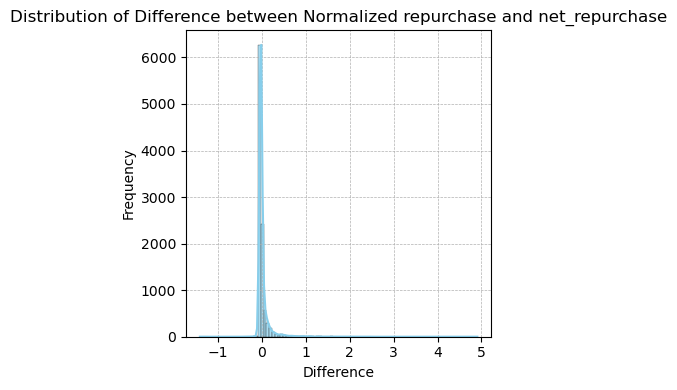

Correlation between repurchase and net_repurchase: 0.984060

Mean Difference (Normalized): 0.017525
Standard Deviation (Normalized): 0.187662
95% Confidence Interval (Normalized): (0.013888, 0.021161)


In [52]:
normalized_difference(df, 'repurchase', 'net_repurchase')

As the mean difference is close to zero and the standard deviation is small, we confirm that the missing values are interchangable

## 10.4 Substitution

In [53]:
mask_rsi_14d_missing = df['repurchase_normalized'].isna() & df['net_repurchase_normalized'].notna()
df.loc[mask_rsi_14d_missing, 'repurchase_normalized'] = df.loc[mask_rsi_14d_missing, 'net_repurchase_normalized']
mask_rsi_30d_missing = df['net_repurchase_normalized'].isna() & df['repurchase_normalized'].notna()
df.loc[mask_rsi_30d_missing, 'net_repurchase_normalized'] = df.loc[mask_rsi_30d_missing, 'repurchase_normalized']

In [54]:
mean_repurchase = df['repurchase'].mean()
std_repurchase = df['repurchase'].std()
mean_net_repurchase = df['net_repurchase'].mean()
std_net_repurchase = df['net_repurchase'].std()

mask_repurchase = (df['repurchase'].isna() & df['net_repurchase'].notna())
df.loc[mask_repurchase, 'repurchase'] = (df['repurchase_normalized'] * std_repurchase) + mean_repurchase
mask_net_repurchase = (df['net_repurchase'].isna() & df['repurchase'].notna())
df.loc[mask_net_repurchase, 'net_repurchase'] = (df['net_repurchase_normalized'] * std_net_repurchase) + mean_net_repurchase

# 11. CONCLUSION

1. **Total Return:**
    - The neighboring values exhibited a strong correlation.
    - In cases where the total return for a specific time frame was missing, I substituted it with the normalized value of the subsequent time frame.
    
    
2. **Capex and Net Capex:**
    - Net capex is derived as capex minus sales of long-term assets.
    - Given their high correlation and the infrequent occurrence of long-term asset sales, they often shared identical values.
    - Thus, when only one of the two was missing, I utilized normalization to substitute the value of the other, followed by denormalization.
    
    
3. **Short-term WC, Long-term WC, and Modified WC:**
    - Their correlation was moderate, not sufficiently strong for substitution.
    - We predominantly rely on short-term WC.  
    
    
4. **EBITDA, EBIT, and Net Income:**
    - In the absence of a `net_income_normalized` value, I used the `ebit_normalized` value.
    - When either `ebit_normalized` or `ebitda_normalized` was missing, I filled the missing column with the value of the other.
    - Subsequent denormalization was performed.
    
    
5. **EBITDA Margin and Operating Margin:**
    - Their high statistical and semantic correlation justified substitution.
    - When only one of the two values was missing, I substituted using the normalized value of the other. 
    
    
6. **RSI 14D and RSI 30D:**
    - Their strong correlation was evident, and there were 13 rows with only `rsi_30d` missing.
    - I employed normalization to substitute `rsi_14d` values where necessary, followed by denormalization. 
    
    
7. **Volatility:**
    - No rows were available for substitution.   
    
    
8. **Normalized ROE & Operating ROE**:
    - Their high semantic and statistical correlation made them suitable for substitution.
    - When only one was missing, I substituted using the normalized value of the other, followed by denormalization.
    
    
9. **EPS GAAP Basic, EPS GAAP Diluted, and EPS Adjusted Diluted:**
    - Given that `eps_adjusted_diluted` has the fewest missing values and is the industry standard, we prioritize this metric. 


10. **Repurchase and Net Repurchase:**
    - Net repurchase is calculated as the repurchase amount minus net stocks issued.
    - Their high correlation, coupled with the rarity of stock reissues, often results in identical values for both metrics.
    - I followed the familiar process of normalization and denormalization for substitution.

# 12. Export the csv file

In [55]:
# drop all the columns of the normalized values
cols_to_drop = [col for col in df.columns if col.endswith('_normalized')]
df.drop(columns=cols_to_drop, inplace=True)
df.to_csv('../database/2016-2022_semantic_imputation.csv', index=False)